---
    Gabriel Graells Solé - gabriel.graells01@estudiant.upf.edu
---

# LSTM Fake News Detector

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchtext.legacy import data
from torch.utils.data import TensorDataset, random_split,DataLoader, RandomSampler, SequentialSampler
from collections import Counter
from sklearn.metrics import accuracy_score

import gc
import re
import string
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

from collections import Counter
import numpy as np
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from google.colab import drive

drive.mount('/content/drive/')
PATH = "/content/drive/My Drive/TFG/FINAL/LSTM/"
torch.manual_seed(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#!python -m spacy download en_core_web_md

In [4]:
#Activate GPU computing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
dataset = pd.read_csv(f"{PATH}data/data.csv")

count_authors = dataset["Author"].value_counts()
authors_list = [k for k,v in count_authors.items() if v > 5]

dataset_ = dataset.loc[dataset['Author'].isin(authors_list)]

In [6]:
dataset_

,Title,Tags,Author,Target
0,"Says Ron Johnson referred to ""The Lego Movie"" ...",Corporations SmallBusiness Wisconsin RussFeingold,RussFeingold,0
3,"Says Virginia Gov. Ralph Northam said, ‘You wi...",Fakenews FacebookFact-checks Guns Facebookposts,Facebookposts,1
4,Figures for September 2014’s job growth in Wis...,Jobs Wisconsin ScottWalker,ScottWalker,0
6,"""Our state has fewer science, technology, engi...",WestVirginia Education Science Technology E.Go...,E.GordonGee,0
7,"Says Hillary Clinton helped ""get done"" the Chi...",HealthCare Florida BillClinton,BillClinton,0
...,...,...,...,...
17800,"""$2.4 million of the NIH dollars was spent on ...",Ebola PublicHealth Virginia RandPaul,RandPaul,0
17802,"Rep. Dan Donovan ""voted for Tax Cuts""",Taxes NewYork DonaldTrump,DonaldTrump,0
17803,"Experts say the property tax ""is the most harm...",RhodeIsland Economy Taxes LincolnChafee,LincolnChafee,1
17805,"""I had previously said that NATO was obsolete ...",National ForeignPolicy Military Terrorism Dona...,DonaldTrump,1


In [7]:
y = dataset_["Target"]
X = dataset_.drop(columns = ["Target"])
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test_, X_val_, y_test, y_val = train_test_split(X_test_, y_test,  test_size = 0.1, random_state = 42)

In [8]:
X.head()

,Title,Tags,Author
0,"Says Ron Johnson referred to ""The Lego Movie"" ...",Corporations SmallBusiness Wisconsin RussFeingold,RussFeingold
3,"Says Virginia Gov. Ralph Northam said, ‘You wi...",Fakenews FacebookFact-checks Guns Facebookposts,Facebookposts
4,Figures for September 2014’s job growth in Wis...,Jobs Wisconsin ScottWalker,ScottWalker
6,"""Our state has fewer science, technology, engi...",WestVirginia Education Science Technology E.Go...,E.GordonGee
7,"Says Hillary Clinton helped ""get done"" the Chi...",HealthCare Florida BillClinton,BillClinton


In [9]:
TEXT = data.Field(tokenize="spacy", batch_first=True, include_lengths = True)
LABEL = data.LabelField(dtype= torch.float,batch_first=True)

In [10]:
stemming = PorterStemmer()
STOPWORDS = set(stopwords.words("english"))

In [11]:
def getTerms(terms):
    terms = terms.lower() 
    terms = terms.translate(str.maketrans("","", string.punctuation))
    terms = terms.split()
    terms = [t for t in terms if t not in STOPWORDS] # perhaps remove it 
    terms = [stemming.stem(t) for t in terms]
    terms = ' '.join(x for x in terms)
    return terms

def word2num(data, min_freq = 5) :
    corpus = data["Title"].apply(lambda x: getTerms(x))
    one_corpus = ' '.join(x for x in corpus.values).split()
    word_count = Counter(one_corpus)
    word2num_dic = dict(enumerate([k for k,v in word_count.items() if v > min_freq], start = 1))   
    word2num_dic = {v:k for k,v in word2num_dic.items()}
    return word2num_dic

def getAuthors(data, min_freq = 5) :
    authors_list = []
    for name, count in dict(data["Author"].value_counts()).items() :
        if count > min_freq:
            authors_list.append(name)
    return authors_list

def vectorise_title(list_string, dim_vector, word2num_dic) :
    vectorised_strings = []
    for string_ in list_string:
        vector = []
        tokens = string_.split()
        for word in tokens:
            if word in word2num_dic :
                vector.append(word2num_dic[word])
            else :
                vector.append(0)
        vectorised_strings.append(vector)

    for i, vector in enumerate(vectorised_strings):
        if len(vector) > dim_vector:
            vector = vector[:dim_vector]
            vectorised_strings[i] = np.asarray(vector)
        else:
            size_pad = dim_vector - len(vector)
            vectorised_strings[i] = np.pad(vector, size_pad, mode="constant")[size_pad:]

    vectorised_strings = np.asarray(vectorised_strings)
    return vectorised_strings

def vectorise_authors(features_author, authors_list) :
    dim = len(authors_list)
    vectorised_author = np.zeros((len(features_author), dim), dtype="int16")
    for i, auth in enumerate(features_author):
        if auth in authors_list:
            index = authors_list.index(auth)
            vectorised_author[i][index] = 1
    return vectorised_author

def combine_features (features_title, features_author) :
    dim = (len(features_title), features_title.shape[1]+features_author.shape[1])
    features = np.empty(dim, dtype="int16")
    for i in range(len(features_title)) :
        buff = np.append(features_title[i], features_author[i])
        features[i] = buff
    return features

def preprocessing(data, word2num_dic, authors_list, dim_vector = 70) :
    features_title = data["Title"].apply(lambda x: getTerms(x))
    features_author = vectorise_authors(data["Author"], authors_list)
    features_title = vectorise_title(features_title, dim_vector, word2num_dic)
    features = combine_features(features_title, features_author)
    return features

In [12]:
# Preprocessing dataset
word2num_dic = word2num(X_train_)
authors_list = getAuthors(X_train_)

X_train = preprocessing(X_train_, word2num_dic, authors_list)
X_test = preprocessing(X_test_, word2num_dic, authors_list)
X_val = preprocessing(X_val_, word2num_dic, authors_list)

**DATA**
* Title: [0:70]
* Author: [70:369]

In [13]:
# Transform to tensor dataset
batch_size = 20
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.values))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test.values))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val.values))
train_loader = DataLoader(train_data,shuffle = True, batch_size = batch_size, drop_last = True)
test_loader = DataLoader(test_data,shuffle = True, batch_size = batch_size, drop_last = True)
val_loader = DataLoader(val_data,shuffle = True, batch_size = batch_size, drop_last = True)

In [14]:
# Model Class
class FakeNet(nn.Module) :
    def __init__(self, kargs) :
        super(FakeNet, self).__init__()
        self.outputs = 1
        self.lstm_num_layers =kargs["lstm_num_layers"] # Title
        self.embed_dim = kargs["embedding_dimension"]
        self.hidden_dim = kargs["hidden_dimension"]
        self.auth_dim = kargs["auth_dim"]             # Author
        self.auth_num_layers = kargs["auth_num_layers"]
        self.linear_1_num_layers = kargs["linear_1_num_layers"] # Combined
        self.linear_2_num_layers = kargs["linear_2_num_layers"]
        self.drop_rate = kargs["drop_rate"]
        # LSTM Title
        self.embedding = nn.Embedding(kargs["vocab_len"], self.embed_dim)
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, self.lstm_num_layers, dropout=self.drop_rate, batch_first = True)
        # Author
        self.linear_author = nn.Linear(self.auth_dim, self.auth_num_layers)
        # Combined Desne + Dense + Dropout + Dense_output
        self.linear_1 = nn.Linear(self.auth_num_layers+self.hidden_dim*70, self.linear_1_num_layers) # 70 -> max num words per title  
        self.linear_2 = nn.Linear(self.linear_1_num_layers,self.linear_2_num_layers)
        self.dropout = nn.Dropout(self.drop_rate)
        self.linear_output = nn.Linear(self.linear_2_num_layers, self.outputs)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def hidden_initialize(self, batch_size) :
        weights = next(self.parameters()).data
        hidden=(weights.new(self.lstm_num_layers, batch_size, self.hidden_dim).zero_().to(device),weights.new(self.lstm_num_layers,batch_size,self.hidden_dim).zero_().to(device))
        return hidden

    def forward(self, cell, hiddens) :
        batch_size = cell.size(0)
        cell = cell.long()
        title = cell[:,:70]
        author = cell[:,70:369].float()
        
        # Embedding + LSTM title
        embedding = self.embedding(title)
        lstm_output, hiddens = self.lstm(embedding, hiddens)
        lstm_output = lstm_output.contiguous().view(batch_size, self.hidden_dim * 70) # 70 -> max num words per title    
        lstm_output = self.dropout(lstm_output)
        # Dense + Relu authors
        author_output = self.linear_author(author)
        author_output = self.relu(author_output)
        
        #Concat
        input_concat = torch.cat((lstm_output,author_output), axis = 1)
        
        #Dense1 + Dense2 + Dropout + Dense3 
        output = self.linear_1(input_concat)
        output = self.relu(output)
        output = self.linear_2(output)
        output = self.relu(output)
        
        output = self.linear_output(output)
        output = self.sigmoid(output)
        
        output = output[:,-1]

        return output, hiddens

In [15]:
def train(num_epochs, model, min_valid_loss = 99**3, clip = 5) :
    model.train()
    count = 0
    target_loss = 1
    for i in range(num_epochs) :
        model_hidden = model.hidden_initialize(batch_size)
    
        for inputs, labels in train_loader:
            count += 1
            model_hidden = tuple([ele.data for ele in model_hidden])
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.zero_grad()
            res = model(inputs, model_hidden)
            outputs = res[0]
            model_hidden = res[1]
            curr_loss = criteria(outputs.squeeze(), labels.float())
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            curr_loss.backward()
            optimizer.step()

            if count%100 == 0:
                valid_h = model.hidden_initialize(batch_size)
                valid_losses = []
                model.eval()
                for input, labeling in val_loader:
                    valid_h = tuple([each.data for each in valid_h])
                    input, labeling = input.to(device), labeling.to(device)
                    out_of_cell, valid_h = model(input, valid_h)
                    valid_loss = criteria(out_of_cell.squeeze(), labeling.float())
                    valid_losses.append(valid_loss.item())
                
                model.train()
                valid_loss_mean = np.mean(valid_losses)
                if valid_loss_mean < target_loss:
                    print("Lowest loss found, saving model.")
                    target_loss = valid_loss_mean
                    torch.save(model.state_dict(), f'{PATH}Version2/models/model_v2.pt')
                print("Now epoch ", i+1, " out of ", num_epochs)
                print("Count:  ",count)
                print("Valid loss: ",valid_loss_mean)
                print("Training loss: ",float(curr_loss))
                print("---")

In [16]:
hyperparameters = {
             "lstm_num_layers": 4,
             "drop_rate": 0.5,
             "embedding_dimension": 300,
             "hidden_dimension": 128,
             "auth_num_layers": 512, 
             "vocab_len":  len(word2num_dic) + 1,
             "linear_1_num_layers": 256,
             "linear_2_num_layers": 128,
             "auth_dim": len(authors_list),
             "num_epochs": 3,
             "clip": 5, # max norm gradient vec
             "learning_rate": 0.0001
             }  
model = FakeNet(hyperparameters)
model.to(device)

criteria = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = hyperparameters["learning_rate"])

In [17]:
train(num_epochs = hyperparameters["num_epochs"], model = model, clip = hyperparameters["clip"])

Lowest loss found, saving model.
Now epoch  1  out of  3
Count:   100
Valid loss:  0.692325069623835
Training loss:  0.6920279860496521
---
Lowest loss found, saving model.
Now epoch  1  out of  3
Count:   200
Valid loss:  0.6894970851785996
Training loss:  0.6622018218040466
---
Lowest loss found, saving model.
Now epoch  1  out of  3
Count:   300
Valid loss:  0.6790727131506976
Training loss:  0.6706895232200623
---
Lowest loss found, saving model.
Now epoch  1  out of  3
Count:   400
Valid loss:  0.6418992000467637
Training loss:  0.5593413710594177
---
Lowest loss found, saving model.
Now epoch  2  out of  3
Count:   500
Valid loss:  0.5699244807748234
Training loss:  0.6689147353172302
---
Now epoch  2  out of  3
Count:   600
Valid loss:  0.5786982494242051
Training loss:  0.5594801306724548
---
Lowest loss found, saving model.
Now epoch  2  out of  3
Count:   700
Valid loss:  0.5690208498169395
Training loss:  0.6256712675094604
---
Now epoch  2  out of  3
Count:   800
Valid loss

In [18]:
def save_model(accuracy, hyperparameters) :
    model_name = "{:.0f}".format(accuracy * 10000) + "model_v2"
    model_dir = f"{PATH}Version2/models/{model_name}/"
    try:
        os.mkdir(model_dir)
    except:
        pass

    torch.save(model.state_dict(), f'{model_dir}{model_name}.pt')
    fo = open(f"{model_dir}hyperparameters.txt", "w")
    fo.write(f"Accuracy: {accuracy}\n")
    for k,v in hyperparameters.items() :
        fo.write(str(k) + ": " +  str(v) + "\n")
    fo.close()
    
    print("Model Saved.")

In [19]:
#tester results
model.load_state_dict(torch.load(f"{PATH}Version2/models/model_v2.pt"))
model_hidden = model.hidden_initialize(batch_size)
test_run_losses = []
y_pred = []
y_true = []

model.eval()

for inputs, labels in test_loader:
    model_hidden = tuple([each.data for each in model_hidden])
    inputs=inputs.to(device)
    labels =labels.to(device)
    y_true.extend(list(labels))
    res=model(inputs, model_hidden)
    output= res[0]
    y_pred.extend(list(output))
    model_hidden=res[1]
    go_res=output.squeeze()
    test_loss = criteria(go_res, labels.float())
    test_run_losses.append(test_loss.item())
   
test_loss_mean=np.mean(test_run_losses)

y_pred_binary = [round(float(x)) for x in y_pred]
y_pred = [float(x) for x in y_pred]
y_true = [float(x) for x in y_true]

acc_score = accuracy_score(y_true, y_pred_binary)*100
print(f"Results: test loss: {test_loss_mean}")
print(f"Fake News accuracy: {acc_score}%")

save_model(acc_score, hyperparameters)

Results: test loss: 0.5827226549386978
Fake News accuracy: 69.4375%
Model Saved.


In [20]:
# Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc, RocCurveDisplay, accuracy_score

def metrics(y_pred_, y_true_) :
    y_pred_binary = [round(float(x)) for x in y_pred_]
    y_pred_ = [float(x) for x in y_pred_]
    y_true_ = [float(x) for x in y_true_]

    # Confusion matrix
    fig, axes = plt.subplots(1,1, figsize=(8,7))
    cm = confusion_matrix(y_true_, y_pred_binary)
    sns.heatmap(cm, annot=True,fmt="d", ax=axes, cmap='Blues', xticklabels =['True','False'], yticklabels=['True','False'])
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    fig.savefig(f'{PATH}Version2/cmv2False.pdf')
    plt.show()

    # Avg recall score
    recall = recall_score(y_true_, y_pred_binary) 
    print(f'* Average Recall Score: {recall}')

    # Avg precision score
    precision = precision_score(y_true_, y_pred_binary)
    print(f'* Average Precision Score: {precision}')

    # F1 score
    f1 = f1_score(y_true_, y_pred_binary)
    print(f'* Average F1 Score: {f1}')

    # Accuracy score
    acc = accuracy_score(y_true_, y_pred_binary)
    print(f'* Average Accuracy Score: {acc}')

    # ROC score
    fig_, axes = plt.subplots(1,1, figsize=(8,7))
    fpr, tpr, thresholds = roc_curve(y_true_, y_pred_)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='ROC')
    display.plot(ax = axes)  
    plt.title('ROC Curve')
    fig_.savefig(f'{PATH}Version2/rocv2False.pdf')
    plt.show()    

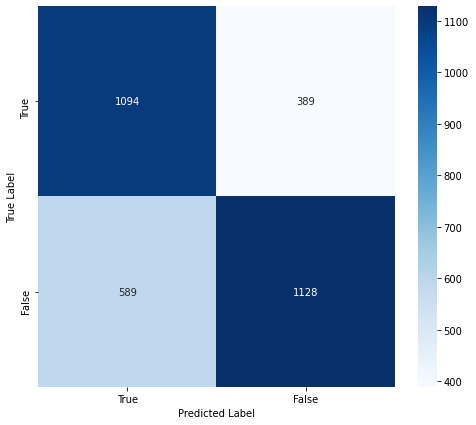

* Average Recall Score: 0.6569598136284217
* Average Precision Score: 0.7435728411338167
* Average F1 Score: 0.6975881261595548
* Average Accuracy Score: 0.694375


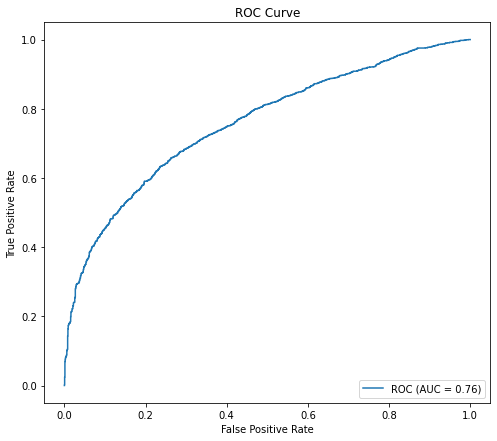

In [21]:
metrics(y_pred, y_true)

## Bias assessment - Performance assessment
 
A bias assessment of the dataset and thus for the model is going to be performed in the subsequent code snippets. By analyzing the errors per Author the bias can be observed. The bias assessment will be performed for both the most trustworthy authors and the most untrustworthy authors obtained in the EDA section.

In [22]:
trust_authors = ['HillaryClinton','BarackObama', 'AndrewCuomo', 'BernieSanders', 'TimKaine', 'CoryBooker', 'SherrodBrown', 'BillClinton', 'RobPortman', 'ElizabethWarren']
untrust_authors = ['DonaldTrump', 'DemocraticCongressionalCampaignCommittee', 'MicheleBachmann', 'Tweets', 'RushLimbaugh', 'Facebookposts', 'Chainemail', 'Instagramposts', 'Bloggers', 'Viralimage']

# Prep dataloader
X_trust_ = dataset_[dataset_['Author'].isin(trust_authors)]
y_trust_ = X_trust_['Target']
X_trust_ = X_trust_.drop(columns=['Target'])
X_untrust_ = dataset_[dataset_['Author'].isin(untrust_authors)]
y_untrust_ = X_untrust_['Target']
X_untrust_ = X_untrust_.drop(columns=['Target'])

X_trust = preprocessing(X_trust_, word2num_dic, authors_list)
X_untrust = preprocessing(X_untrust_, word2num_dic, authors_list)

X_trust = TensorDataset(torch.from_numpy(X_trust), torch.from_numpy(y_trust_.values))
trust_loader = DataLoader(X_trust,shuffle = True, batch_size = batch_size, drop_last = True)
X_untrust = TensorDataset(torch.from_numpy(X_untrust), torch.from_numpy(y_untrust_.values))
untrust_loader = DataLoader(X_untrust,shuffle = True, batch_size = batch_size, drop_last = True)

In [25]:
# Trustworhty authors classification
model.load_state_dict(torch.load(f"{PATH}Version2/models/model_v2.pt"))
model_hidden = model.hidden_initialize(batch_size)
test_run_losses = []
y_pred_trust = []
y_true_trust = []

model.eval()

for inputs, labels in trust_loader:
    model_hidden = tuple([each.data for each in model_hidden])
    inputs=inputs.to(device)
    labels =labels.to(device)
    y_true_trust.extend(list(labels))
    res=model(inputs, model_hidden)
    output= res[0]
    y_pred_trust.extend(list(output))
    model_hidden=res[1]
    go_res=output.squeeze()
    test_loss = criteria(go_res, labels.float())
    test_run_losses.append(test_loss.item())
   
test_loss_mean=np.mean(test_run_losses)

y_pred_binary_trust = [round(float(x)) for x in y_pred_trust]
y_pred_trust = [float(x) for x in y_pred_trust]
y_true_trust = [float(x) for x in y_true_trust]

acc_score = accuracy_score(y_true_trust, y_pred_binary_trust)*100
print(f"Results: test loss: {test_loss_mean}")
print(f"Fake News accuracy: {acc_score}%")

save_model(acc_score, hyperparameters)

Results: test loss: 0.5347308120690286
Fake News accuracy: 74.765625%
Model Saved.


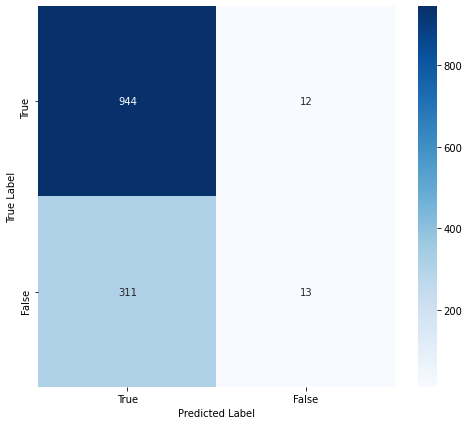

* Average Recall Score: 0.040123456790123455
* Average Precision Score: 0.52
* Average F1 Score: 0.07449856733524356
* Average Accuracy Score: 0.74765625


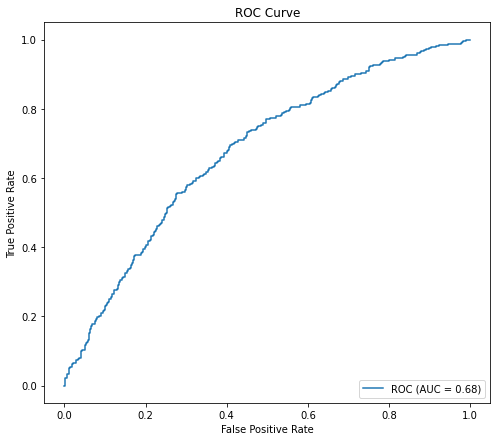

In [26]:
# Metrics Trustworthy
metrics(y_pred_trust, y_true_trust)

In [27]:
# Untrustworhty authors classification
model.load_state_dict(torch.load(f"{PATH}Version2/models/model_v2.pt"))
model_hidden = model.hidden_initialize(batch_size)
test_run_losses = []
y_pred_untrust = []
y_true_untrust = []

model.eval()

for inputs, labels in untrust_loader:
    model_hidden = tuple([each.data for each in model_hidden])
    inputs=inputs.to(device)
    labels =labels.to(device)
    y_true_untrust.extend(list(labels))
    res=model(inputs, model_hidden)
    output= res[0]
    y_pred_untrust.extend(list(output))
    model_hidden=res[1]
    go_res=output.squeeze()
    test_loss = criteria(go_res, labels.float())
    test_run_losses.append(test_loss.item())
   
test_loss_mean=np.mean(test_run_losses)

y_pred_binary_untrust = [round(float(x)) for x in y_pred_untrust]
y_pred_untrust = [float(x) for x in y_pred_untrust]
y_true_untrust = [float(x) for x in y_true_untrust]

acc_score = accuracy_score(y_true_untrust, y_pred_binary_untrust)*100
print(f"Results: test loss: {test_loss_mean}")
print(f"Fake News accuracy: {acc_score}%")

save_model(acc_score, hyperparameters)

Results: test loss: 0.3702657808860143
Fake News accuracy: 86.06060606060606%
Model Saved.


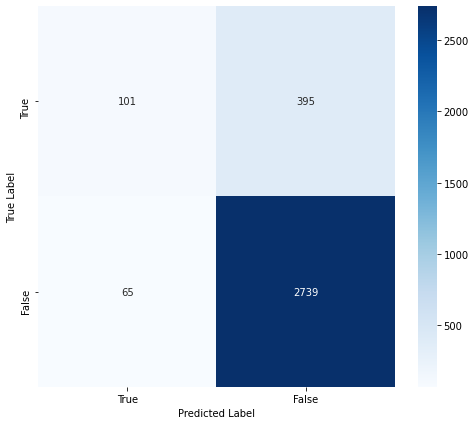

* Average Recall Score: 0.9768188302425107
* Average Precision Score: 0.8739629865985961
* Average F1 Score: 0.9225328393398451
* Average Accuracy Score: 0.8606060606060606


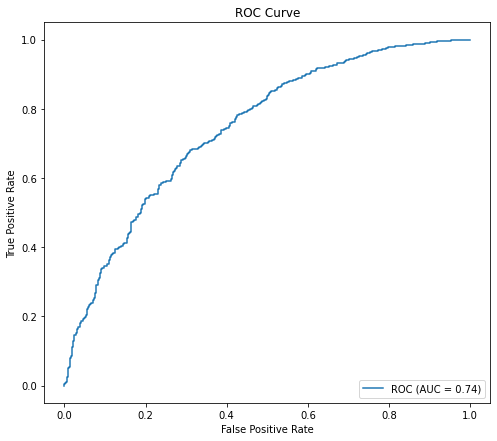

In [28]:
# Metrics
metrics(y_pred_untrust, y_true_untrust)